In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
data = pd.read_csv('data/combined_data_cleaned.csv')

In [3]:
data.head()

,date,state,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations_per_million,share_doses_used,fips,deaths,new_cases,total_cases,population
0,2020-01-21,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,1,1,7614800
1,2020-01-22,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,1,7614800
2,2020-01-23,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,1,7614800
3,2020-01-24,Illinois,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0,1,1,12672400
4,2020-01-24,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,1,7614800


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26359 entries, 0 to 26358
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 26359 non-null  object 
 1   state                                26359 non-null  object 
 2   total_vaccinations                   9020 non-null   float64
 3   total_distributed                    9020 non-null   float64
 4   people_vaccinated                    9020 non-null   float64
 5   people_fully_vaccinated_per_hundred  9020 non-null   float64
 6   total_vaccinations_per_hundred       9020 non-null   float64
 7   people_fully_vaccinated              9020 non-null   float64
 8   people_vaccinated_per_hundred        9020 non-null   float64
 9   distributed_per_hundred              9020 non-null   float64
 10  daily_vaccinations_raw               9020 non-null   float64
 11  daily_vaccinations_per_milli

Preprocessing Section

In [5]:
#create new feature that lists the number of new cases based on total population

data['new_cases_per_hundred'] = data['new_cases'] / data['population'] * 100

In [6]:
#drop all columns that are not relevant to the model

model_data = data[['date', 'state', 'people_vaccinated_per_hundred', 'new_cases_per_hundred']]

In [7]:
model_data.head()

,date,state,people_vaccinated_per_hundred,new_cases_per_hundred
0,2020-01-21,Washington,NaN,0.000013
1,2020-01-22,Washington,NaN,0.000000
2,2020-01-23,Washington,NaN,0.000000
3,2020-01-24,Illinois,NaN,0.000008
4,2020-01-24,Washington,NaN,0.000000


In [8]:
#We want to predict number of new cases 7 days ahead using the following lag variables:
#number of new cases 7 days behind
#rolling average of number of new cases from 14 to 7 days behind [7 day rolling average]
#rolling average of number of new cases from 10 to 7 days behind [3 day rolling average]
#number of people vaccinated 7 days behind

In [9]:
#number of new cases 7 days behind

model_data['new_cases_per_hundred_t-7'] = model_data['new_cases_per_hundred'].groupby(model_data['state']).shift(periods=7, fill_value=0)

<ipython-input-9-23ec106eafcf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['new_cases_per_hundred_t-7'] = model_data['new_cases_per_hundred'].groupby(model_data['state']).shift(periods=7, fill_value=0)


In [10]:
#rolling average of number of new cases from 14 to 7 days behind [7 day rolling average]

model_data['new_cases_per_hundred_rolling_7'] = model_data['new_cases_per_hundred_t-7'].groupby(model_data['state']).transform(lambda s: s.rolling(7).mean())

<ipython-input-10-c95414d910fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['new_cases_per_hundred_rolling_7'] = model_data['new_cases_per_hundred_t-7'].groupby(model_data['state']).transform(lambda s: s.rolling(7).mean())


In [11]:
#rolling average of number of new cases from 10 to 7 days behind [3 day rolling average]

model_data['new_cases_per_hundred_rolling_3'] = model_data['new_cases_per_hundred_t-7'].groupby(model_data['state']).transform(lambda s: s.rolling(3).mean())

<ipython-input-11-8682dfda2d4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['new_cases_per_hundred_rolling_3'] = model_data['new_cases_per_hundred_t-7'].groupby(model_data['state']).transform(lambda s: s.rolling(3).mean())


In [12]:
#number of people vaccinated 7 days behind

model_data['people_vaccinated_per_hundred_t-7'] = model_data['people_vaccinated_per_hundred'].groupby(model_data['state']).shift(periods=7)

<ipython-input-12-477355801f66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['people_vaccinated_per_hundred_t-7'] = model_data['people_vaccinated_per_hundred'].groupby(model_data['state']).shift(periods=7)


In [13]:
#number of total unique dates

model_data['date'].nunique()

521

In [14]:
#number of unique dates since vaccinations

model_data[model_data['people_vaccinated_per_hundred'].notnull()]['date'].nunique()

164

In [15]:
#find the first date with vaccination data (2021-01-12)

model_data.date = pd.to_datetime(model_data.date)
first = model_data[model_data['people_vaccinated_per_hundred'].notnull()]['date'].take([0])

C:\Users\USFK04487\Anaconda3\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
#find the 100th date with vaccination data (to be used for training set)

first + timedelta(days=100)

17339   2021-04-22
Name: date, dtype: datetime64[ns]

In [17]:
#fill all remaining missing values in dataframe with 0

model_data.fillna(value=0, inplace=True)

C:\Users\USFK04487\Anaconda3\lib\site-packages\pandas\core\frame.py:4314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [18]:
#add first 100 days of vaccination data to training set, rest to testing set

train = model_data.loc[model_data['date']<='2021-04-22']
test = model_data.loc[model_data['date']>'2021-04-22']

In [19]:
#split train and test into X and y

X_train = train[['new_cases_per_hundred_t-7', 'people_vaccinated_per_hundred_t-7', 'new_cases_per_hundred_rolling_7', 'new_cases_per_hundred_rolling_3']]
X_test = test[['new_cases_per_hundred_t-7', 'people_vaccinated_per_hundred_t-7', 'new_cases_per_hundred_rolling_7', 'new_cases_per_hundred_rolling_3']]
y_train = train['new_cases_per_hundred']
y_test = test['new_cases_per_hundred']

Modeling Section

In [20]:
#We will try various regression models from sklearn, including:
#KNeighborsRegressor
#DecisionTreeRegressor
#ExtraTreeRegressor
#SVR
#AdaBoostRegressor
#BaggingRegressor
#RandomForestRegressor
#GradientBoostingRegressor

In [21]:
#import the models

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [22]:
#create dictionary containing all of the models
#write a function that fits and predicts on all of the models in the dictionary and saves the predicted values into a dataframe
#and the errors into a dictionary

from sklearn.metrics import mean_absolute_error

n_trees=100
models = {'knn': KNeighborsRegressor(), 'dec': DecisionTreeRegressor(), 'extra': ExtraTreeRegressor(), 'svr': SVR(),
          'ada': AdaBoostRegressor(n_estimators=n_trees), 'bag': BaggingRegressor(n_estimators=n_trees),
          'rf': RandomForestRegressor(n_estimators=n_trees), 'et': ExtraTreesRegressor(n_estimators=n_trees),
          'gbm': GradientBoostingRegressor(n_estimators=n_trees)}

predictions = pd.DataFrame()
absolute_errors = {}

for name, model in models.items():
    local_model = model.fit(X_train, y_train)
    y_pred = local_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    predictions[name] = y_pred
    absolute_errors[name] = mae

In [23]:
#check the maes for each of the models and determine the lowest

absolute_errors

{'knn': 0.015102892413590247,
 'dec': 0.005592104543559955,
 'extra': 0.005245948358657502,
 'svr': 0.09292815512556882,
 'ada': 0.02430657624127288,
 'bag': 0.004270360423276282,
 'rf': 0.004448560496258019,
 'et': 0.004080085732555967,
 'gbm': 0.003641386690613483}

In [24]:
#Gradient Boosting seems to result in the lowest MAE

In [25]:
#hyperparameter tuning for GB model

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

params = {'max_depth': [3, 10, 1000], 'min_samples_leaf': [1, 50, 100], 'n_estimators': [500]}
cv = TimeSeriesSplit(n_splits=3).split(X_train, y_train)

clf = GridSearchCV(GradientBoostingRegressor(), params, cv=cv)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 500}

In [26]:
#get MAE for the best performing GBR model

gbr = GradientBoostingRegressor(max_depth=3, min_samples_leaf=100, n_estimators=500)
gbr_fit = gbr.fit(X_train, y_train)
gbr_pred = gbr_fit.predict(X_test)
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mae

0.00313717423639046

In [27]:
gbr_fit.feature_importances_

array([0.70342899, 0.01731216, 0.04829412, 0.23096473])

In [28]:
#it looks like number of people vaccinated does not have much predictive power

In [29]:
#why is the mean of y_test so low? does this mean the errors are really high?

np.mean(test['new_cases_per_hundred'])

0.008051444906903496

Evaluating the Model

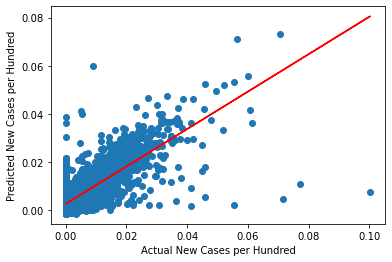

Slope:  0.7759809158084839


In [30]:
#plot of y_pred to y_true

m, b = np.polyfit(y_test, gbr_pred, 1)

_ = plt.scatter(y_test, gbr_pred)
_ = plt.xlabel('Actual New Cases per Hundred')
_ = plt.ylabel('Predicted New Cases per Hundred')
_ = plt.plot(y_test, y_test*m+b, color='red')
plt.show()

print('Slope: ', m)

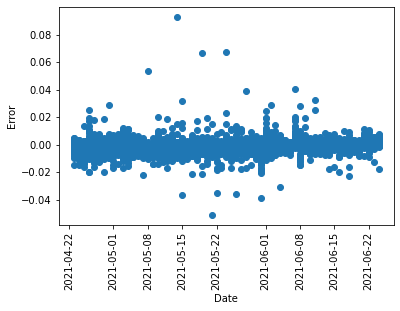

In [36]:
#plot of the distribution of error between y_pred and y_true

_ = plt.scatter(test['date'], y_test - gbr_pred)
_ = plt.xlabel('Date')
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Error')
plt.show()

In [32]:
#create a baseline model with predicted new cases equal to cases from 7 days prior

baseline_pred = X_test['new_cases_per_hundred_t-7']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mae

0.0032879188635372954

In [33]:
#our model is only slightly better than the baseline - maybe we should look at different features?

In [35]:
#create another baseline model with all the same features except vaccination data

X_train_novax = X_train.drop('people_vaccinated_per_hundred_t-7', axis=1)
X_test_novax = X_test.drop('people_vaccinated_per_hundred_t-7', axis=1)

gbr_novax = GradientBoostingRegressor(max_depth=3, min_samples_leaf=100, n_estimators=500)
gbr_novax_fit = gbr.fit(X_train_novax, y_train)
gbr_novax_pred = gbr_novax_fit.predict(X_test_novax)
gbr_novax_mae = mean_absolute_error(y_test, gbr_novax_pred)
gbr_novax_mae

0.004210810389462777

In [ ]:
"""
#try MPE on a subset of the data (where new cases is high)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#predictions = pd.DataFrame()
#absolute_errors = {}
percentage_errors = {}

train_ny = model_data.loc[(model_data['date']<='2021-04-22') & (model_data['state']=='New York')]
test_ny = model_data.loc[(model_data['date']>'2021-04-22') & (model_data['state']=='New York')]

X_train = train_ny[['new_cases_per_hundred_t-7', 'people_vaccinated_per_hundred_t-7', 'new_cases_per_hundred_rolling_7', 'new_cases_per_hundred_rolling_3']]
X_test = test_ny[['new_cases_per_hundred_t-7', 'people_vaccinated_per_hundred_t-7', 'new_cases_per_hundred_rolling_7', 'new_cases_per_hundred_rolling_3']]
y_train = train_ny['new_cases_per_hundred']
y_test = test_ny['new_cases_per_hundred']

for name, model in models.items():
    local_model = model.fit(X_train, y_train)
    y_pred = local_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mpe = mean_absolute_percentage_error(y_test, y_pred)
#    predictions[name] = y_pred
#    absolute_errors[name] = mae
    percentage_errors[name] = mpe
"""

In [ ]:
"""

#we will test the model prediction on a 1 day lead time:

#prepare the supervised learning dataset
check_data = data[['date', 'state', 'people_vaccinated_per_hundred', 'new_cases_per_hundred']]
check_data['new_cases_per_hundred_t-1'] = check_data['new_cases_per_hundred'].groupby(model_data['state']).shift(periods=1, fill_value=0)
check_data['new_cases_per_hundred_rolling_7'] = check_data['new_cases_per_hundred_t-1'].groupby(model_data['state']).transform(lambda s: s.rolling(7).mean())
check_data['new_cases_per_hundred_rolling_3'] = check_data['new_cases_per_hundred_t-1'].groupby(model_data['state']).transform(lambda s: s.rolling(3).mean())
check_data['people_vaccinated_per_hundred_t-1'] = data['people_vaccinated_per_hundred'].groupby(model_data['state']).shift(periods=1)

check_data.fillna(value=0, inplace=True)

check_train = check_data.loc[check_data['date']<='2021-04-22']
check_test = check_data.loc[check_data['date']>'2021-04-22']

X_train_check = check_train[['new_cases_per_hundred_t-1', 'people_vaccinated_per_hundred_t-1', 'new_cases_per_hundred_rolling_7', 'new_cases_per_hundred_rolling_3']]
X_test_check = check_test[['new_cases_per_hundred_t-1', 'people_vaccinated_per_hundred_t-1', 'new_cases_per_hundred_rolling_7', 'new_cases_per_hundred_rolling_3']]
y_train_check = check_train['new_cases_per_hundred']
y_test_check = check_test['new_cases_per_hundred']

gbr_check = GradientBoostingRegressor()
gbr_fit_check = gbr_check.fit(X_train_check, y_train_check)
gbr_pred_check = gbr_fit_check.predict(X_test_check)
gbr_mae_check = mean_absolute_error(y_test_check, gbr_pred_check)
gbr_mae_check

"""

In [ ]:
#gbr_fit_check.feature_importances_